# Preprocessing of ProThermDB.
Requires the files 'ProTherm_wildtypes.tsv', 'ProTherm_single.tsv', 'ProTherm_multiple.tsv'.


Create the directories '.../seqdata/' as well as '.../MSA/' to save the individual sequences as well as the folder where the MSAs will be processed and saved. 
You will most likely run into errors with directories not existing while running this script.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
import requests, sys
import os

CURRENT_DIR = os.getcwd()
PROTHERMDB_WT_FILE = 'ProTherm_wildtypes.tsv'
PROTHERMDB_SINGLE_FILE = 'ProTherm_single.tsv'
PROTHERMDB_MULTI_FILE = 'ProTherm_multiple.tsv'
FILES = [PROTHERMDB_WT_FILE, PROTHERMDB_SINGLE_FILE, PROTHERMDB_MULTI_FILE]
files = os.listdir('preprocess')

df = pd.DataFrame() #df is the dataframe that will contain all relevant information
if 'raw_formatted.csv' in files:
    df = pd.read_csv('preprocess/raw_formatted.csv')
else:
    for file in FILES:
        raw = pd.read_table(file, na_values='-')
        raw = raw.drop('NO', axis='columns') #unneccesary indexing

        raw = raw.dropna(subset=['UniProt_ID', 'MUTATION']) #remove entries w/o ID or mutation
        raw = raw.drop_duplicates().reset_index()
        raw = raw.rename(columns={'∆G_(kcal/mol)':'dG', 
                                  '∆∆G_(kcal/mol)':'ddG', 
                                  '∆G_H2O_(kcal/mol)':'dG_H20', 
                                  '∆∆G_H2O_(kcal/mol)':'ddG_H20', 
                                  'Tm_(C)':'Tm', 
                                  '∆Tm_(C)':'dTm', 
                                  '∆H_(kcal/mol)': 'dH',
                                  '∆Cp_(kcal/mol)': 'dCp',
                                  '∆HvH_(kcal/mol)': 'dHvH'})

        #Remove white spaces from ID
        raw['UniProt_ID'] = raw['UniProt_ID'].str.replace(' ', '')

        #Make the mutation infomation less cluttered
        #raw['MUTATION'] = raw['MUTATION'].replace('wild-type', 'WT')
        raw['MUTATION'] = raw['MUTATION'].str.replace(';', '')
        raw['MUTATION'] = raw['MUTATION'].str.replace(',', '')
        raw['MUTATION'] = raw['MUTATION'].str.split('(')
        for index in range(raw.shape[0]):
            raw['MUTATION'].iloc[index] = raw['MUTATION'].loc[index][0]
        raw['MUTATION'] = raw['MUTATION'].str.strip()
        raw['MUTATION'] = raw['MUTATION'].str.replace(' ', '_')
        print('Done with formatting mutation formatting')

        #Drop entries with no stability information
        raw = raw.dropna(subset=['dG', 'ddG', 'dG_H20', 'ddG_H20', 'Tm', 'dTm'], how='all')

        #Ensure that the numerical values are properly formatted
        for col_name in ['pH','T_(C)', 'dG', 'ddG', 'dG_H20', 'ddG_H20', 'Tm', 'dTm', 'dH', 'dCp', 'dHvH']:
            raw.loc[:,col_name] = raw[col_name].astype('str')
            raw.loc[:,col_name] = raw[col_name].str.split('(')
            for index in range(raw.shape[0]):
                if not type(raw[col_name].iloc[index]) == np.float64:
                    raw.loc[:,col_name].iloc[index] = raw[col_name].iloc[index][0]
            raw.loc[:,col_name] = raw[col_name].str.replace(' ', '') #gets rid of blank spaces
            raw.loc[:,col_name] = raw[col_name].str.replace('−', '-') #an entry has the wrong sign sign to signify negative number
            raw.loc[:,col_name] = pd.to_numeric(raw[col_name], errors='coerce')

        df = pd.concat([df, raw], axis=0)

    #Ensure that wildtype entries don't have ddG, ddG_H20 or dTm values.
    df = df.replace(to_replace='wild-type', value='WT')
    drop = []
    for index in range(df.shape[0]):
        if df['MUTATION'].iloc[index] == 'wild-type':
            if (not np.isnan(df['ddG'].iloc[index])) or (not np.isnan(df['ddG_H20'].iloc[index])) or (not np.isnan(df['dTm'].iloc[index])):
                drop.append(index)
    df = df.drop(drop, axis='index').reset_index(drop=True)
    df.to_csv('preprocess/raw_formatted.csv', index=False)

/tmp/ipykernel_3305582/1575852333.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['MUTATION'].iloc[index] = raw['MUTATION'].loc[index][0]


Done with formatting mutation formatting


/tmp/ipykernel_3305582/1575852333.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw.loc[:,col_name].iloc[index] = raw[col_name].iloc[index][0]
/tmp/ipykernel_3305582/1575852333.py:61: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  raw.loc[:,col_name] = pd.to_numeric(raw[col_name], errors='coerce')
/tmp/ipykernel_3305582/1575852333.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['MU

Done with formatting mutation formatting


/tmp/ipykernel_3305582/1575852333.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw.loc[:,col_name].iloc[index] = raw[col_name].iloc[index][0]
/tmp/ipykernel_3305582/1575852333.py:61: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  raw.loc[:,col_name] = pd.to_numeric(raw[col_name], errors='coerce')
/tmp/ipykernel_3305582/1575852333.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['MU

Done with formatting mutation formatting


/tmp/ipykernel_3305582/1575852333.py:61: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  raw.loc[:,col_name] = pd.to_numeric(raw[col_name], errors='coerce')


# Plotting to visualize at which conditions the experiments were conducted at.
To view plots de-comment code

In [3]:
# pH = df['pH']
# print('==== pH without cut-off =====')
# print('nan\t\t' + str(df['pH'].isna().sum()))
# print(pH.describe())
# plt.figure(1)
# plt.plot(pH,'k.')
# plt.xlabel('Index')
# plt.ylabel('pH')
# plt.title('pH without cut-off')

# plt.figure(2)
# plt.hist(pH, bins=12)
# plt.xlabel('pH')
# plt.xticks(range(13))
# plt.ylabel('Frequency')
# plt.title('pH without cut-off')


# temp = df['T_(C)']
# print('====Temp without cut-off ====')
# print('nan\t\t' + str(df['T_(C)'].isna().sum()))
# print(temp.describe())
# plt.figure(3)
# plt.plot(temp,'k.')
# plt.xlabel('Index')
# plt.ylabel('Temperature (C)')
# plt.title('Temperature (C) without cut-off')

# plt.figure(4)
# plt.hist(temp, bins=12)
# plt.xlabel('Temperature (C)')
# #plt.xticks(range(13))
# plt.ylabel('Frequency')
# plt.title('Temperature (C) without cut-off')

## Initial cut-off is temp [15, 35] and pH [5, 9]

In [4]:
# #Cut-off of entries with temperature over 15 C and below 35 C
cutoff = df.copy()
temp1 = cutoff[cutoff['T_(C)'].isna()]       #These three lines of codes lets entries with NaN pH and temperature go thorugh
temp2 = cutoff[cutoff['pH'].isna()]
temp = pd.concat([temp1, temp2], axis=0)
cutoff = cutoff[cutoff['T_(C)'] < 35]
cutoff = cutoff[cutoff['T_(C)'] > 15]
cutoff = pd.concat([cutoff, temp], axis=0)   #Together with this line of code
cutoff = cutoff[cutoff['pH'] < 9]
cutoff = cutoff[cutoff['pH'] > 5]
cutoff = cutoff.set_index('index')
cutoff = cutoff.reset_index()

# if showFigs:
#     temp = cutoff['T_(C)']
#     print('====Temp with temp and pH cut-off ====')
#     print('nan\t\t' + str(cutoff['T_(C)'].isna().sum()))
#     print(cutoff['T_(C)'].describe())
#     plt.figure(1)
#     plt.plot(temp,'k.')
#     plt.xlabel('Index')
#     plt.ylabel('Temperature (C)')
#     plt.title('Temperature (C) with temp and pH cut-off')

#     plt.figure(2)
#     plt.hist(temp, bins=12)
#     plt.xlabel('Temperature (C)')
#     #plt.xticks(range(13))
#     plt.ylabel('Frequency')
#     plt.title('Temperature (C) with temp and pH cut-off')

#     #Cut-off on both pH and temp
#     pH = cutoff['pH']
#     print('==== pH with temp and pH cut-off=====')
#     print('nan\t\t' + str(cutoff['pH'].isna().sum()))
#     print(pH.describe())
#     plt.figure(3)
#     plt.plot(pH,'k.')
#     plt.xlabel('Index')
#     plt.ylabel('pH')
#     plt.title('pH with temp and pH cut-off')

#     plt.figure(4)
#     plt.hist(pH)
#     plt.xlabel('pH')
#     plt.xticks(range(5,10))
#     plt.ylabel('Frequency')
#     plt.title('pH with pH and temp cut-off')

# Merge dG with dG_H20, and ddG with ddG_H20 respectively
We approximate that they should yield the same value

In [5]:
df[['dG', 'ddG', 'dG_H20', 'ddG_H20']].describe()
df['dG'] = df[['dG','dG_H20']].mean(axis=1)
df['ddG'] = df[['ddG','ddG_H20']].mean(axis=1)
df = df.drop(['dG_H20', 'ddG_H20'], axis='columns')

# For entries conducted at multiple pH and Temperature levels. Keep the ones at most neutral pH and temperature
Method for choosing values.
1. Remove entries with pH outside of [5, 9] and temperature outside of [15, 35], however keep entries with NaN values of these two conditions (to keep up the number of entries).
2. For entries within the interval and the same UniProt_ID and mutation, calculate the mean of pH, temparature, Tm, dTm, dH, dCp, dHvH, dG and ddG.


In [6]:
if 'Nonredundant_entries_ProThermDB.csv' in files:
    df = pd.read_csv('preprocess/preprocess/Nonredundant_entries_ProThermDB.csv')
else:
    missingpH = df[df['pH'].isna()]
    missingTemp = df[df['T_(C)'].isna()]
    missingpHTemp = missingpH[missingpH['T_(C)'].isna()]


    df = df[df['pH'] > 5]
    df = df[df['pH'] < 9]
    df = df[df['T_(C)'] > 15]
    df = df[df['T_(C)'] < 35]

    missingTemp = missingTemp[missingTemp['pH'] > 5]
    missingTemp = missingTemp[missingTemp['pH'] < 9]
    missingpH = missingpH[missingpH['T_(C)'] > 15]
    missingpH = missingpH[missingpH['T_(C)'] < 35]

    df = pd.concat((df, missingpH, missingTemp, missingpHTemp))

    uniqueIDMut = df.drop_duplicates(subset=['UniProt_ID', 'MUTATION'], keep=False)
    #Summarises duplicates of ID and Mutation into data with only one point. This will have to be appened to the non-duplicates.
    meanofdups = pd.DataFrame()
    newindex = raw.shape[0]

    isIDDup = df['UniProt_ID'].duplicated(keep=False)
    dupIDs = df['UniProt_ID'][isIDDup].drop_duplicates()
    for dupID in dupIDs:
        isMutDup = df.loc[df['UniProt_ID'] == dupID, 'MUTATION'].duplicated(keep=False)
        dupMuts = df.loc[df['UniProt_ID'] == dupID, 'MUTATION'][isMutDup].drop_duplicates()
        for dupMut in dupMuts:
            #Among the twins. Calculate the mean values.
            twins = df[(df['UniProt_ID'] == dupID) & (df['MUTATION'] == dupMut)]
            meanTwins = twins.mean()
            modifiedEntry = twins.iloc[0]
            modifiedEntry['MEASURE'] = np.nan
            modifiedEntry['METHOD'] = np.nan
            modifiedEntry['index'] = newindex
            modifiedEntry.loc['pH': 'T_(C)'] = meanTwins[['pH', 'T_(C)']]
            modifiedEntry.loc['Tm': 'ddG'] = meanTwins.loc['Tm': 'ddG']

            meanofdups = pd.concat((meanofdups, modifiedEntry), axis=1)
            newindex += 1

    # Nested list into DataFrame

    # Concatinate the non-redundant part with the averaged no-longer redudantant part
    newdf = pd.concat([uniqueIDMut, meanofdups.transpose()])
    print('The operation could narow down ' + str(df.shape[0]) + ' twin-entries down to ' + str(newdf.shape[0]) + '.')
    df = newdf
    df.to_csv('preprocess/Nonredundant_entries_ProThermDB.csv', index=False)

/tmp/ipykernel_3305582/192383980.py:34: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  meanTwins = twins.mean()
/tmp/ipykernel_3305582/192383980.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modifiedEntry['MEASURE'] = np.nan
/tmp/ipykernel_3305582/192383980.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modifiedEntry['METHOD'] = np.nan
/tmp/ipykernel_3305582/192383980.py:38: Sett

The operation could narow down 14544 twin-entries down to 5647.


## Time to once again look at the distribution of pH and Temperature

In [7]:
# pH = df['pH']
# print('==== pH =====')
# print('nan\t\t' + str(df['pH'].isna().sum()))
# print(pH.describe())
# plt.figure(1)
# plt.plot(pH,'k.')
# plt.xlabel('Index')
# plt.ylabel('pH')
# plt.title('pH')

# plt.figure(2)
# plt.hist(pH, bins=12)
# plt.xlabel('pH')
# plt.xticks(range(5,9))
# plt.ylabel('Frequency')
# plt.title('pH')


# temp = df['T_(C)']
# print('====Temp ====')
# print('nan\t\t' + str(df['T_(C)'].isna().sum()))
# print(temp.describe())
# plt.figure(3)
# plt.plot(temp,'k.')
# plt.xlabel('Index')
# plt.ylabel('Temperature (C)')
# plt.title('Temperature (C) ')

# plt.figure(4)
# plt.hist(temp, bins=12)
# plt.xlabel('Temperature (C)')
# #plt.xticks(range(13))
# plt.ylabel('Frequency')
# plt.title('Temperature (C)')

# Downloading FASTAS

In [8]:
#%% Function to make the gathering easier
def get_url(url, **kvargs):
    response = requests.get(url, **kvargs);
    
    if not response.ok:
        print(response.text)
        response.raise_for_status()
        sys.exit()
        
    return response

#%% Go through all of the UniProtIDs nonredundantly to gather the associated FASTA files
if 'ProTherm_w_FASTA.csv' in files:
    df =  pd.read_csv('preprocess/ProTherm_w_FASTA.csv')
else:
    IDs = df['UniProt_ID']
    IDsNoDup = IDs.drop_duplicates()
    df['FASTA'] = '-'

    WEBSITE_API = "https://rest.uniprot.org/uniprotkb/"
    for id in IDsNoDup:
        url = WEBSITE_API + id.strip() + '.fasta'
        FASTA = get_url(url).text  
        df.loc[df['UniProt_ID'] == id, 'FASTA'] = FASTA

    #FASTA to sequence
    df['seq'] = df['FASTA'].str.split('\n')
    for index in range(df.shape[0]):
        df['seq'].iloc[index] = df['seq'].iloc[index][1:]
    df['seq'] = df['seq'].str.join('')

    df['seqlen'] = -1
    for index in range(df.shape[0]):
        df['seqlen'].iloc[index] = len(df['seq'].iloc[index])
    df = df.drop('seq', axis='columns')
    df.to_csv('preprocess/ProTherm_w_FASTA.csv', index=False)

/tmp/ipykernel_3305582/71660463.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seqlen'].iloc[index] = len(df['seq'].iloc[index])


# Make ddG into dG 
Merge the information of ddG with dG into dG.
Meaning: if an entry has a ddG value but no dG, find the dG of the wildtype and calculate the dG.

In [9]:
isIDDup = df['UniProt_ID'].duplicated(keep=False)
dupIDs = df['UniProt_ID'][isIDDup].drop_duplicates()

noWT = 0
for dupID in dupIDs:
    group = df[df['UniProt_ID'] == dupID]
    wt = group[group['MUTATION'] == 'WT']
    dGisna = group['dG'].isna()
    nodG = group[dGisna]
    try:
        plus =  wt['dG'].mean() + nodG['ddG']
        group['dG'].loc[dGisna] = plus
        df[df['UniProt_ID'] == dupID] = group
    except IndexError:
        noWT += 1

/tmp/ipykernel_3305582/1293746729.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['dG'].loc[dGisna] = plus


# Make dTm into Tm

In [10]:
isIDDup = df['UniProt_ID'].duplicated(keep=False)
dupIDs = df['UniProt_ID'][isIDDup].drop_duplicates()

noWT = 0
for dupID in dupIDs:
    group = df[df['UniProt_ID'] == dupID]
    wt = group[group['MUTATION'] == 'WT']
    Tmisna = group['Tm'].isna()
    noTm = group[Tmisna]
    try:
        plus =  wt['Tm'].mean() + noTm['dTm']
        group['Tm'].loc[Tmisna] = plus
        df[df['UniProt_ID'] == dupID] = group
    except IndexError:
        noWT += 1

df['Tm'] += 273

/tmp/ipykernel_3305582/2677036501.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['Tm'].loc[Tmisna] = plus


# Plot sequence lenghts

In [11]:
#At this point all entries should have either Tm or dG
df[(df['dG'].isna()) & (df['Tm'].isna())]

# seqlen = df['seqlen']
# print('==== Sequence length before cut-off =====')
# print('nan\t\t' + str(df['seqlen'].isna().sum()))
# print(seqlen.describe())
# plt.figure(1)
# plt.plot(seqlen,'k.')
# plt.xlabel('Index')
# plt.ylabel('Length')
# plt.title('Sequence lengths before cut-off')

# plt.figure(2)
# plt.hist(seqlen, bins=12)
# plt.xlabel('Length')
# #plt.xticks()
# plt.ylabel('Frequency')
# plt.title('Sequence lengths before cut-off')

df = df[df['seqlen'] < 512]
df = df[df['seqlen'] > 40]

# seqlen = df['seqlen']
# print('==== Sequence length after cut-off =====')
# print('nan\t\t' + str(df['seqlen'].isna().sum()))
# print(seqlen.describe())
# plt.figure(3)
# plt.plot(seqlen,'k.')
# plt.xlabel('Index')
# plt.ylabel('Length')
# plt.title('Sequence lengths after cut-off')

# plt.figure(4)
# plt.hist(seqlen, bins=12)
# plt.xlabel('Length')
# #plt.xticks()
# plt.ylabel('Frequency')
# plt.title('Sequence lengths after cut-off')

# Alter FASTA to match mutation
Can only run this once, since after alteration it won't be reconized as a proper mutation

In [12]:
df['valid_mutation'] = True
df = df.replace(to_replace='wild-type', value='WT')
numNonmatchOrLong = 0
numError = 0
for index in range(df.shape[0]):
    fasta = df['FASTA'].iloc[index]
    if pd.isnull(fasta):
        df['valid_mutation'].iloc[index] = False
        numNonmatchOrLong += 1
    else:
        seq = fasta.split('\n')
        info = seq[0]
        seq = ''.join(seq[1:])
        if df['MUTATION'].iloc[index] != 'WT':
            temp = df['MUTATION'].iloc[index].split('_')
            for s in temp:
                try:
                    pre = s[0]
                    resnum = int(s[1:-1])
                    post = s[-1]
                    
                    if  seq[resnum - 1] == pre:
                        seq = seq[:resnum - 1] + post + seq[resnum:]
                        s = str()
                        rows = len(seq) // 60 + 1
                        for r in range(rows - 1):
                            s += seq[r*60: (r+1)*60] + '\n'
                        s += seq[(r+1)*60:] + '\n'

                        df['FASTA'].iloc[index] = ">" + df['UniProt_ID'].iloc[index] + "_" + df['MUTATION'].iloc[index] + "\n" + s
                    else:
                        df['valid_mutation'].iloc[index] = False
                        numNonmatchOrLong += 1
                except (IndexError, ValueError):#, ValueError, TypeError, AttributeError):
                    df['valid_mutation'].iloc[index] = False
                    numError = numError + 1
        else:
            s = str()
            rows = len(seq) // 60 + 1
            for r in range(rows - 1):
                s += seq[r*60: (r+1)*60] + '\n'
            s += seq[(r+1)*60:] + '\n'

            df['FASTA'].iloc[index] = ">" + df['UniProt_ID'].iloc[index] + "_" + df['MUTATION'].iloc[index] + "\n" + s

df = df[df['valid_mutation'] == True]
df = df.drop('valid_mutation', axis='columns')
df.to_csv('preprocess/ProTherm_preprocessed.csv')

/tmp/ipykernel_3305582/699758748.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FASTA'].iloc[index] = ">" + df['UniProt_ID'].iloc[index] + "_" + df['MUTATION'].iloc[index] + "\n" + s
/tmp/ipykernel_3305582/699758748.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FASTA'].iloc[index] = ">" + df['UniProt_ID'].iloc[index] + "_" + df['MUTATION'].iloc[index] + "\n" + s
/tmp/ipykernel_3305582/699758748.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

# Plot dG and Tm

/home/lucas/miniconda3/envs/fresh/lib/python3.9/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/lucas/miniconda3/envs/fresh/lib/python3.9/site-packages/numpy/lib/histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Distribution of stability')

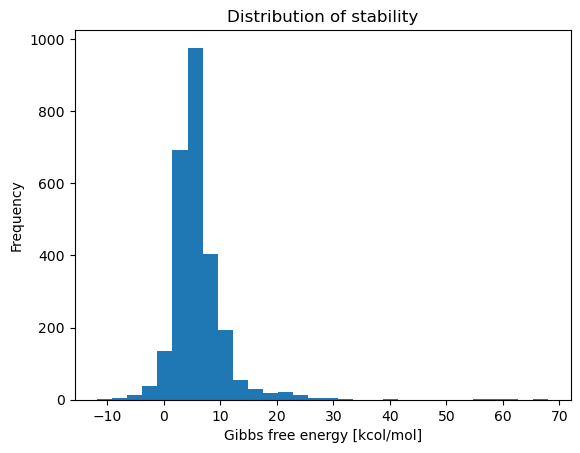

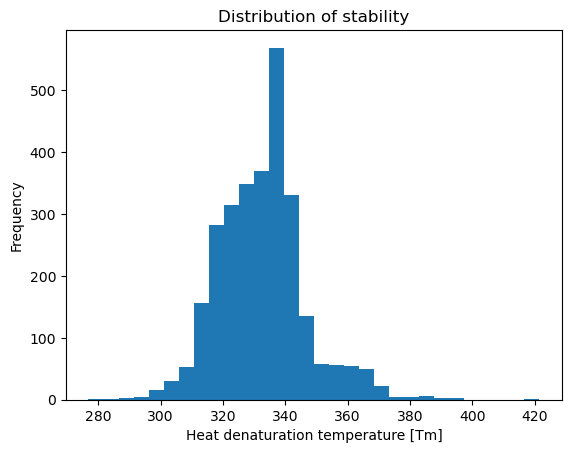

In [13]:
plt.figure(1)
plt.hist(df['dG'], bins=30)
plt.ylabel('Frequency')
plt.xlabel('Gibbs free energy [kcol/mol]')
plt.title('Distribution of stability')

#df = df[df['dG'] < 35]
plt.figure(2)
plt.hist(df['Tm'], bins=30)
plt.ylabel('Frequency')
plt.xlabel('Heat denaturation temperature [Tm]')
plt.title('Distribution of stability')

# The wildtype subset

In [14]:
wt = df.loc[df['MUTATION'] == 'WT']
wt = wt.drop(['ddG'], axis='columns')
wt = wt[wt['dG'].notna()]
wt.describe()

print('===================================')
print('By only selecting the wildtype proteins we go from ' + str(df.shape[0]) + ' number of entries to ' + str(wt.shape[0]))
print('===================================')

By only selecting the wildtype proteins we go from 4724 number of entries to 296


In [16]:
# Save all of the wildtype FASTAs to enable MSA generation of the wildtypes
# (So that I know which are more similar to eachother and how to group them)

FASTA = str()
for fasta in wt['FASTA']:
    FASTA += fasta

with open(CURRENT_DIR + '/preprocess/wildtypes.FASTA', 'w') as file:
    file.write(FASTA)

In [17]:
# Save all of the sequences as FASTA to enable clustering of all sequences.
FASTA = str()
for fasta in df['FASTA']:
    FASTA += fasta

with open(CURRENT_DIR + '/preprocess/all_seqs.FASTA', 'w') as file:
    file.write(FASTA)

In [20]:
#%% Save all FASTAs as sepearate files in the directory seqdata, to enable MSA generation
print(f"Current directory is:\t{CURRENT_DIR}")
if not os.path.exists('seqdata/'):
    os.mkdir('seqdata/')

df['name'] = df['UniProt_ID'] + '_' + df['MUTATION']
for index in range(df.shape[0]):
    file_name = df['name'].iloc[index] + '_.FASTA'
    with open(CURRENT_DIR + '/seqdata/' + file_name, 'w') as file:
        file.write(df['FASTA'].iloc[index])

index_list = ''
names = df['name'].drop_duplicates().tolist()
for n in names:
    index_list += n + '_.FASTA\n'



with open(CURRENT_DIR + '/seqdata/index.txt', 'w') as file:
    file.write(index_list)

Current directory is:	/home/lucas/Protein_Stability_Masters_2023/Preprocessing/ProThermDB


# Scatterplot everything

/tmp/ipykernel_3103149/994441849.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


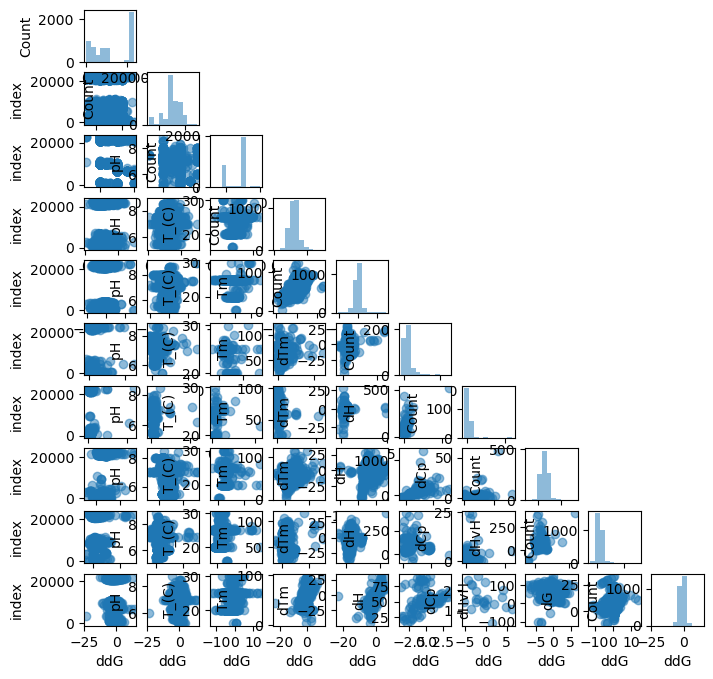

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
import os

os.chdir('/home/lucas/hh-suite/data/ProThermDB_redownload/preprocess')
df = pd.read_csv('Nonredundant_entries_ProThermDB.csv')
d = df.drop(['UniProt_ID', 'MUTATION', 'PDB_wild', 'PDB_Chain_Mutation', 'MEASURE', 'METHOD'], axis='columns')
scatterplotmatrix(d.values, names=d.columns, alpha=0.5) #look up how to actually use with text information
plt.tight_layout()
plt.show()

array([[<Axes: xlabel='index', ylabel='index'>,
        <Axes: xlabel='pH', ylabel='index'>,
        <Axes: xlabel='T_(C)', ylabel='index'>,
        <Axes: xlabel='Tm', ylabel='index'>,
        <Axes: xlabel='dTm', ylabel='index'>,
        <Axes: xlabel='dH', ylabel='index'>,
        <Axes: xlabel='dCp', ylabel='index'>,
        <Axes: xlabel='dHvH', ylabel='index'>,
        <Axes: xlabel='dG', ylabel='index'>,
        <Axes: xlabel='ddG', ylabel='index'>,
        <Axes: xlabel='seqlen', ylabel='index'>],
       [<Axes: xlabel='index', ylabel='pH'>,
        <Axes: xlabel='pH', ylabel='pH'>,
        <Axes: xlabel='T_(C)', ylabel='pH'>,
        <Axes: xlabel='Tm', ylabel='pH'>,
        <Axes: xlabel='dTm', ylabel='pH'>,
        <Axes: xlabel='dH', ylabel='pH'>,
        <Axes: xlabel='dCp', ylabel='pH'>,
        <Axes: xlabel='dHvH', ylabel='pH'>,
        <Axes: xlabel='dG', ylabel='pH'>,
        <Axes: xlabel='ddG', ylabel='pH'>,
        <Axes: xlabel='seqlen', ylabel='pH'>],
       [<Ax

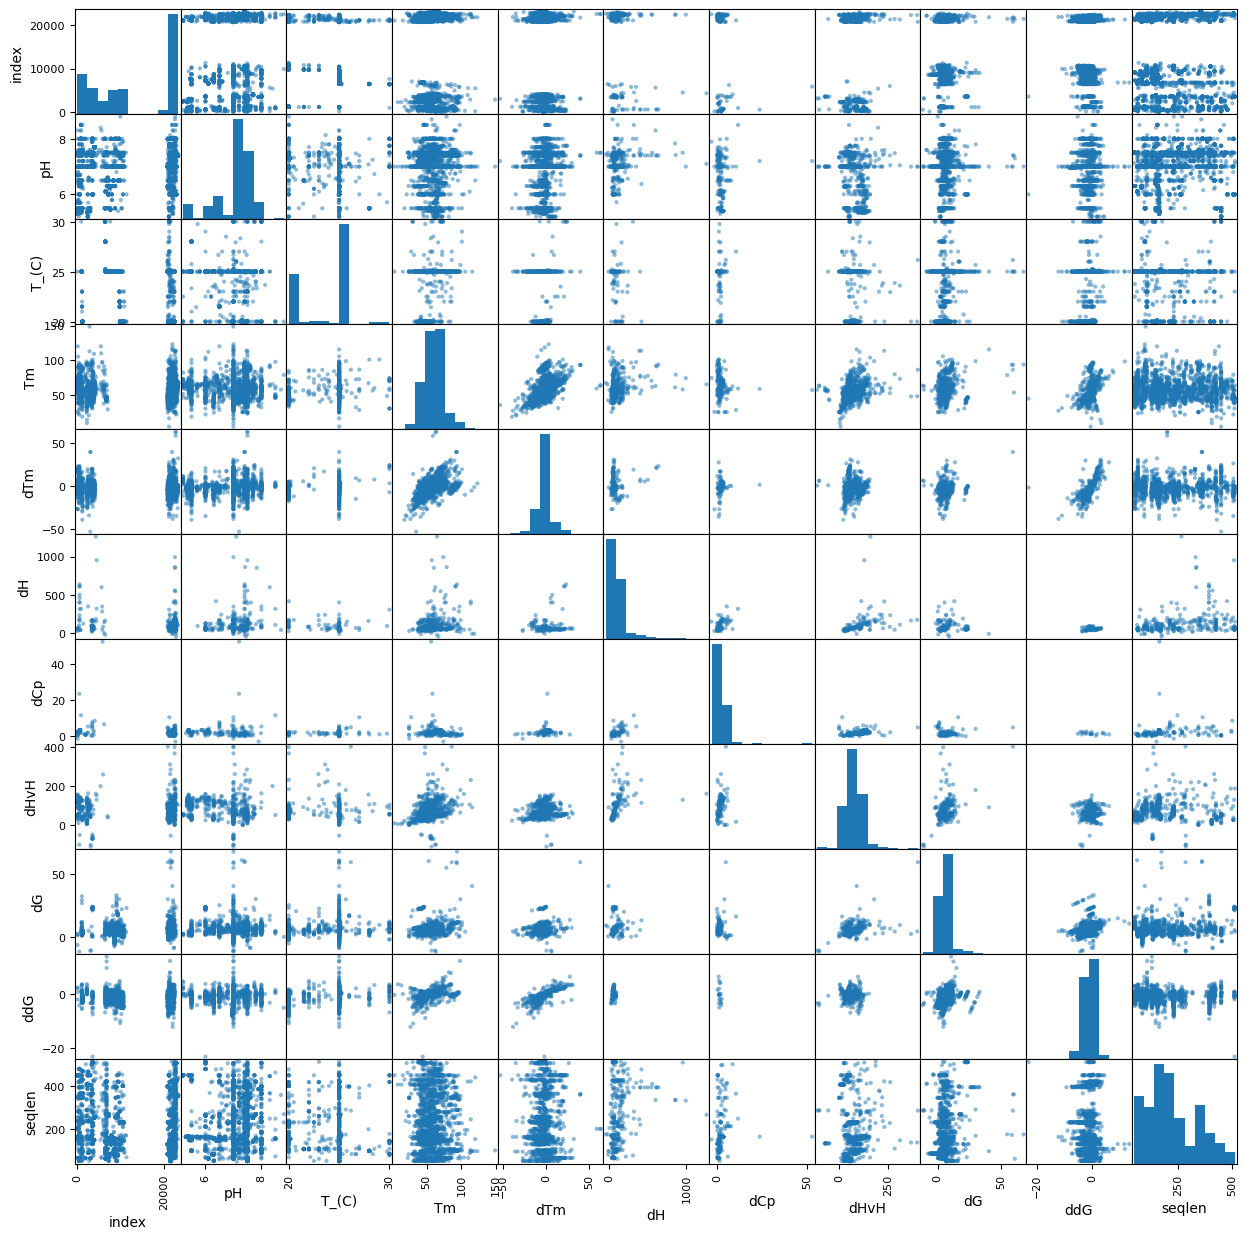

In [8]:
import pandas as pd
df = pd.read_csv('ProTherm_semi_processed_w_seq.csv')
d = df.drop(['Unnamed: 0','UniProt_ID', 'MUTATION', 'PDB_wild', 'PDB_Chain_Mutation', 'MEASURE', 'METHOD', 'FASTA'], axis='columns')
pd.plotting.scatter_matrix(d, alpha=0.5, figsize=(15,15))


# 3D Scatter-plot of deltaG, Tm and sequence length

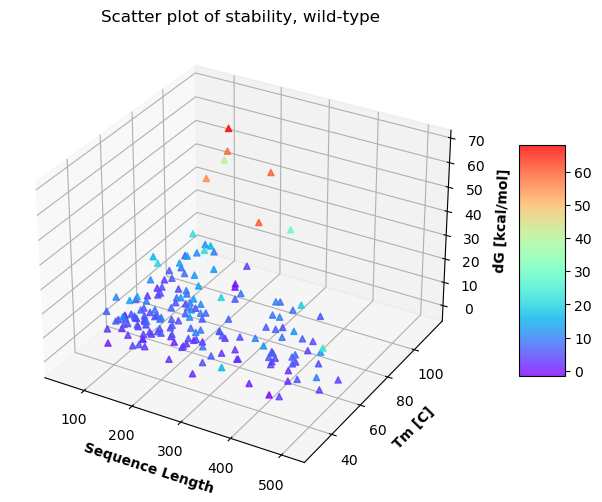

In [89]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(projection='3d')

d = d.dropna(subset=['dG', 'Tm'], axis='index', how='any')

# Creating color map
my_cmap = plt.get_cmap('rainbow')

x = np.array(d['seqlen'])
y = np.array(d['Tm'])
z = np.array(d['dG'])

# Creating plot
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = z,
                    cmap = my_cmap,
                    marker ='^')


# for n in range(d.shape[0]):
#     xs = d['seqlen'].iloc[n]
#     ys = d['Tm'].iloc[n]
#     zs = d['dG'].iloc[n]
#     ax.scatter(xs, ys, zs, c=zs, cmap=my_cmap)

plt.title('Scatter plot of stability, wild-type')
ax.set_xlabel('Sequence Length', fontweight ='bold')
ax.set_ylabel('Tm [C]', fontweight ='bold')
ax.set_zlabel('dG [kcal/mol]', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)


Text(0.5, 1.0, 'Distribution of stability wild-type')

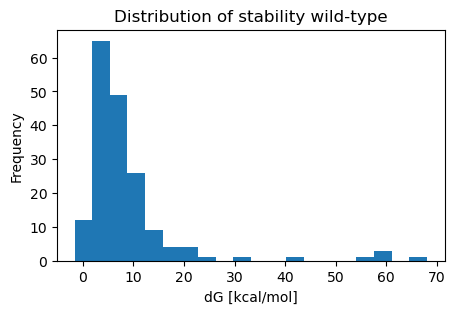

In [82]:
fig = plt.figure(figsize=(5, 3))
plt.hist(d['dG'], bins=20)
plt.xlabel('dG [kcal/mol]')
plt.ylabel('Frequency')
plt.title('Distribution of stability wild-type')

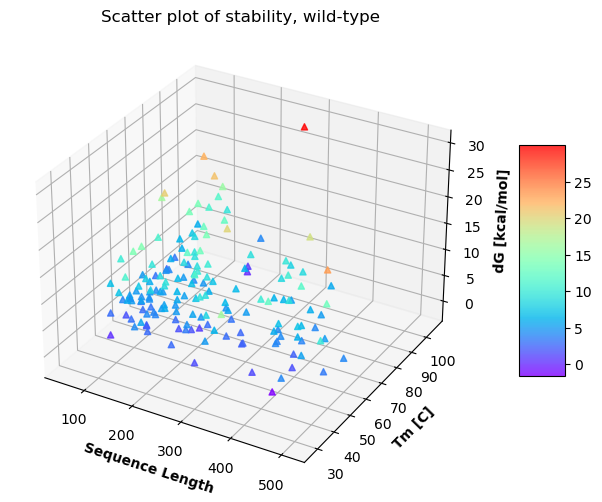

In [85]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(projection='3d')

d = d.dropna(subset=['dG', 'Tm'], axis='index', how='any')
d = d[d['dG'] < 40]

# Creating color map
my_cmap = plt.get_cmap('rainbow')

x = np.array(d['seqlen'])
y = np.array(d['Tm'])
z = np.array(d['dG'])

# Creating plot
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = z,
                    cmap = my_cmap,
                    marker ='^')


# for n in range(d.shape[0]):
#     xs = d['seqlen'].iloc[n]
#     ys = d['Tm'].iloc[n]
#     zs = d['dG'].iloc[n]
#     ax.scatter(xs, ys, zs, c=zs, cmap=my_cmap)

plt.title('Scatter plot of stability, wild-type')
ax.set_xlabel('Sequence Length', fontweight ='bold')
ax.set_ylabel('Tm [C]', fontweight ='bold')
ax.set_zlabel('dG [kcal/mol]', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
